In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
usage_df = pd.read_csv('ventura_c.csv')

In [3]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
0,91320,Ventura County,1,2015,Residential,10188020.0,10.188020
1,91320,Ventura County,1,2015,Commercial,7476972.0,7.476972
2,91360,Ventura County,1,2015,Residential,9910258.0,9.910258
3,91360,Ventura County,1,2015,Commercial,7898338.0,7.898338
4,91361,Ventura County,1,2015,Residential,7851439.0,7.851439


In [4]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7040 entries, 0 to 7039
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ZipCode        7040 non-null   int64  
 1   County         7040 non-null   object 
 2   Month          7040 non-null   int64  
 3   Year           7040 non-null   int64  
 4   CustomerClass  7040 non-null   object 
 5   TotalkWh       7040 non-null   float64
 6   TotalGWh       7040 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 385.1+ KB


In [5]:
# Creating GWh field from converting kWh
usage_df['TotalGWh'] = usage_df['TotalkWh'] / 1000000

In [6]:
# Creating 'Date' column to combine Month and Year
usage_df['Date'] = usage_df['Month'].astype(str) + '-' + usage_df['Year'].astype(str)

In [7]:
usage_df['Date'] = pd.to_datetime(usage_df['Date'], format='%m-%Y')

In [8]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7040 entries, 0 to 7039
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ZipCode        7040 non-null   int64         
 1   County         7040 non-null   object        
 2   Month          7040 non-null   int64         
 3   Year           7040 non-null   int64         
 4   CustomerClass  7040 non-null   object        
 5   TotalkWh       7040 non-null   float64       
 6   TotalGWh       7040 non-null   float64       
 7   Date           7040 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 440.1+ KB


In [9]:
# Setting 'Date' as the index
usage_df = usage_df.set_index('Date')

In [10]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
Date,,,,,,,
2015-01-01,91320,Ventura County,1,2015,Residential,10188020.0,10.188020
2015-01-01,91320,Ventura County,1,2015,Commercial,7476972.0,7.476972
2015-01-01,91360,Ventura County,1,2015,Residential,9910258.0,9.910258
2015-01-01,91360,Ventura County,1,2015,Commercial,7898338.0,7.898338
2015-01-01,91361,Ventura County,1,2015,Residential,7851439.0,7.851439


## Resampling dataframe to total monthly usage

In [11]:
usage = usage_df[['TotalkWh','TotalGWh']].resample('M').sum()

In [12]:
usage.head()

,TotalkWh,TotalGWh
Date,,
2015-01-31,399606638.0,399.606638
2015-02-28,378256268.0,378.256268
2015-03-31,509244647.0,509.244647
2015-04-30,383036294.0,383.036294
2015-05-31,388008689.0,388.008689


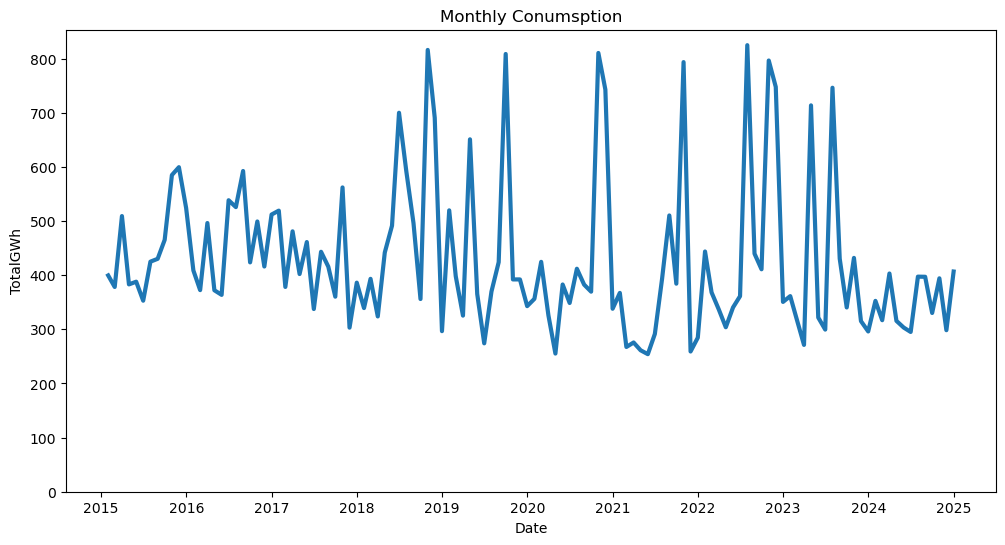

In [13]:
# PLotting data
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], linewidth=3)
plt.title("Monthly Conumsption")
plt.xlabel("Date")
plt.ylabel("TotalGWh")
plt.ylim(ymin=0)
plt.show()

## Implementing SARIMA model

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
# Checking for stationarity of data

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
 
 
check_stationarity(usage['TotalGWh'])

ADF Statistic: -3.0109360948788892
p-value: 0.03388565146143999
Stationary


***SARIMAX model can still handle non-stationary data***

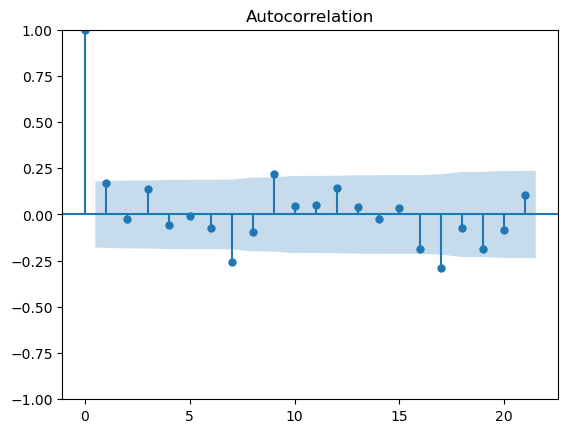

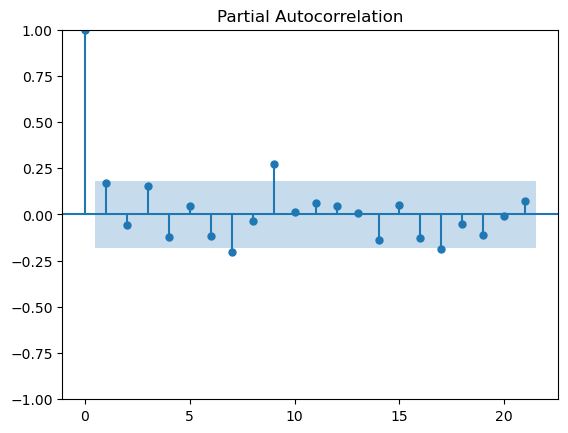

In [16]:
 # Plot ACF and PACF
plot_acf(usage['TotalGWh'])
plot_pacf(usage['TotalGWh'])
plt.show()

## Using AutoArima to find the parameters for SARIMAX model

In [17]:
# Install the library if necessary
# !pip install pmdarima

# Import the library
from pmdarima.arima import auto_arima

# Build and fit the AutoARIMA model
model = auto_arima(usage['TotalGWh'],
                   test='adf',
                   seasonal=True,
                   #max_p=3, max_q=3,
                   start_p=0,
                   d=1,
                   trace=True,
                   start_P=0,
                   m=12,
                   #D=None,
                   stepwise=True,
                   with_intercept=True,
                   suppress_warnings=True)

model.fit(usage['TotalGWh'])

# Check the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1577.030, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1560.552, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1575.030, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1560.141, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1561.084, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1539.022, Time=0.02 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1540.718, Time=0.11 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=1540.809, Time=0.11 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=1540.059, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=i

In [18]:
# p, d, q parameters
model.order

(1, 1, 3)

In [19]:
# P, D, Q, s parameters
model.seasonal_order

(1, 0, 0, 12)

In [20]:
# Define SARIMA parameters from AutoArima results

# Fit the SARIMA model
model = SARIMAX(usage['TotalGWh'], order=model.order, seasonal_order=model.seasonal_order)
results = model.fit()
model

### Forecasting the next 12 months

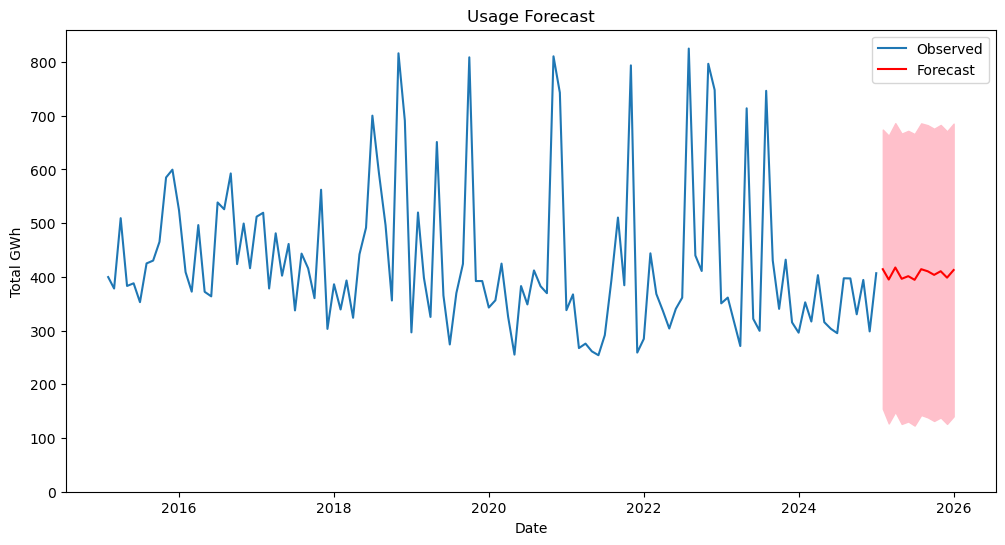

In [21]:
# Forecast future demand
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

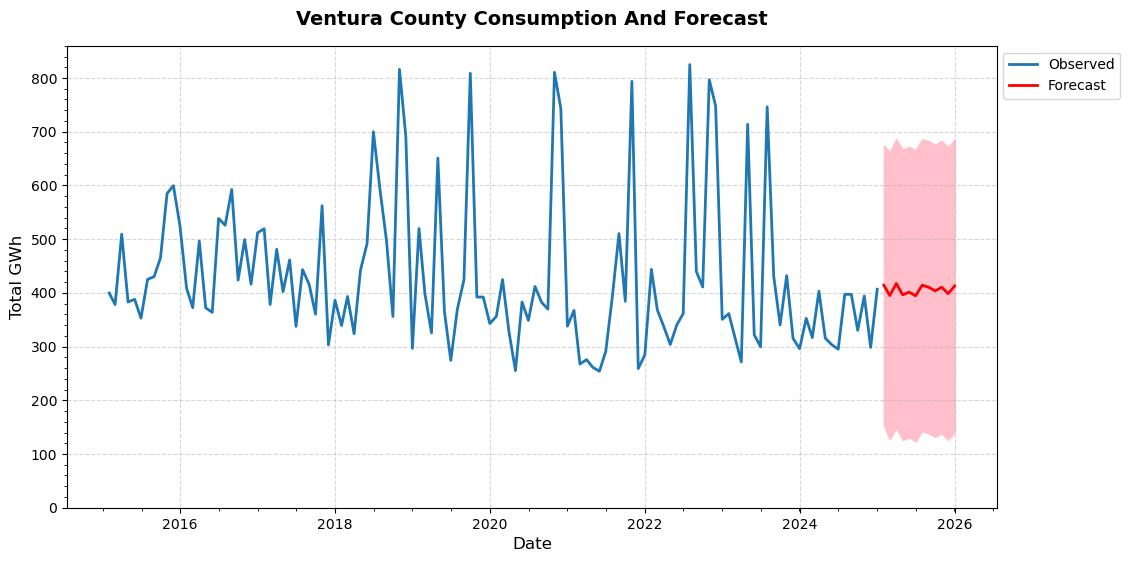

In [22]:
# Alternative Plot
from matplotlib.ticker import AutoMinorLocator


# Plot settings
plt.figure(figsize=(12, 6))
ax1 = sns.lineplot(data=usage['TotalGWh'], label='Observed',linewidth=2)
ax2 = sns.lineplot(data=forecast_mean, label='Forecast', color='red', linewidth=2)

# Fill between forecast confidence intervals
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')


# Plot labels and legend
plt.title("Ventura County Consumption And Forecast", weight='bold', fontsize=14, pad=15)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Total GWh",fontsize=12)
plt.ylim(bottom=0)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.14,1), loc='upper right')

# Show plot
#plt.savefig('ventura_c.png')
plt.show()

### Evaluate Model

In [23]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 54.844089479797695
MSE: 4357.3143445827955
RMSE: 66.00995640494543


In [24]:
observed

Date
2024-01-31    352.580254
2024-02-29    316.846392
2024-03-31    403.143607
2024-04-30    315.652078
2024-05-31    303.294405
2024-06-30    295.145168
2024-07-31    397.346398
2024-08-31    397.096744
2024-09-30    330.246651
2024-10-31    394.252007
2024-11-30    298.428518
2024-12-31    406.804165
Freq: M, Name: TotalGWh, dtype: float64

In [25]:
forecast_mean

2025-01-31    414.278425
2025-02-28    394.967477
2025-03-31    417.424601
2025-04-30    396.408499
2025-05-31    401.291493
2025-06-30    394.494010
2025-07-31    414.284141
2025-08-31    410.369371
2025-09-30    403.699760
2025-10-31    410.487997
2025-11-30    398.538499
2025-12-31    412.721187
Freq: M, Name: predicted_mean, dtype: float64

### Forecasting the next 24 months

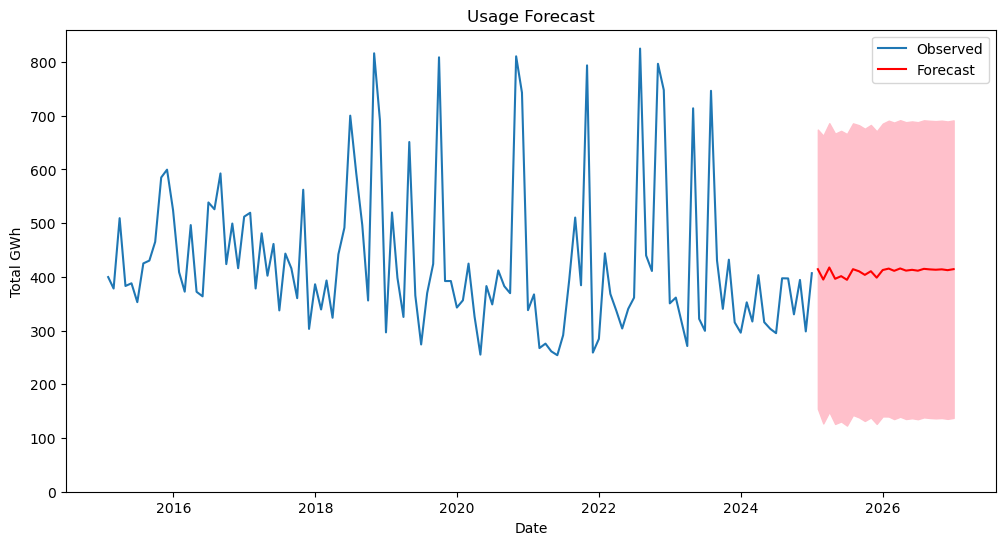

In [26]:
# Forecast future demand
forecast_periods = 24  # Forecast the next 24 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

### Evaluate Model

In [27]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 89.77668929405273
MSE: 14602.778782500123
RMSE: 120.84195787266988


In [28]:
observed

Date
2023-01-31    361.400007
2023-02-28    318.491325
2023-03-31    271.255520
2023-04-30    713.765733
2023-05-31    321.824771
2023-06-30    299.495755
2023-07-31    746.333502
2023-08-31    430.501690
2023-09-30    340.429386
2023-10-31    431.966555
2023-11-30    315.260979
2023-12-31    296.089120
2024-01-31    352.580254
2024-02-29    316.846392
2024-03-31    403.143607
2024-04-30    315.652078
2024-05-31    303.294405
2024-06-30    295.145168
2024-07-31    397.346398
2024-08-31    397.096744
2024-09-30    330.246651
2024-10-31    394.252007
2024-11-30    298.428518
2024-12-31    406.804165
Freq: M, Name: TotalGWh, dtype: float64

In [29]:
forecast_mean

2025-01-31    414.278425
2025-02-28    394.967477
2025-03-31    417.424601
2025-04-30    396.408499
2025-05-31    401.291493
2025-06-30    394.494010
2025-07-31    414.284141
2025-08-31    410.369371
2025-09-30    403.699760
2025-10-31    410.487997
2025-11-30    398.538499
2025-12-31    412.721187
2026-01-31    415.381707
2026-02-28    411.228140
2026-03-31    415.631279
2026-04-30    411.621680
2026-05-31    413.092249
2026-06-30    411.463138
2026-07-31    414.912134
2026-08-31    413.900635
2026-09-30    413.272615
2026-10-31    413.978318
2026-11-30    412.458268
2026-12-31    414.350706
Freq: M, Name: predicted_mean, dtype: float64

In [30]:
customer_consum = usage_df.groupby('CustomerClass')['TotalGWh'].sum()
customer_consum

CustomerClass
Agricultural     3022.120606
Commercial      15980.617056
Industrial      15909.177566
Residential     16577.682428
Name: TotalGWh, dtype: float64

In [31]:
customer_df = customer_consum.reset_index()
customer_df

,CustomerClass,TotalGWh
0,Agricultural,3022.120606
1,Commercial,15980.617056
2,Industrial,15909.177566
3,Residential,16577.682428


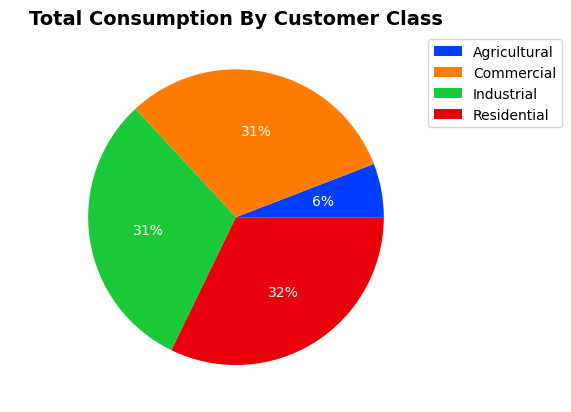

In [32]:
# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass']
       ,colors=palette_color, autopct='%.0f%%', textprops=dict(color='w'))
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()

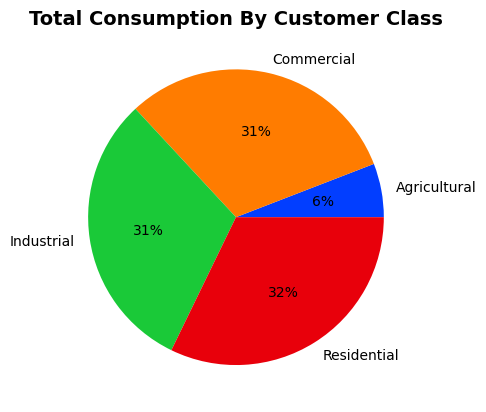

In [33]:
# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass']
       ,colors=palette_color, autopct='%.0f%%', textprops=dict(color='black'))
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
#plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()

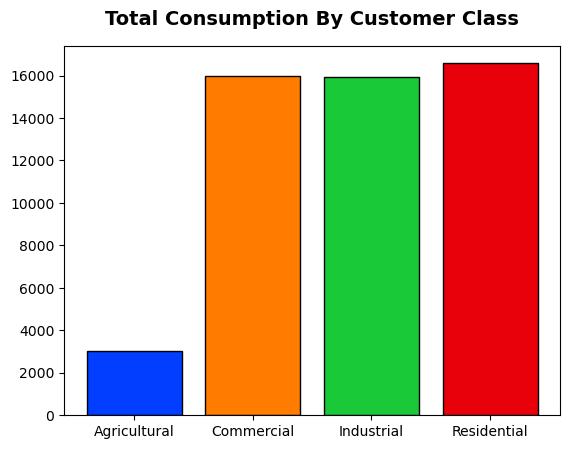

In [34]:
# Bar chart
plt.bar(customer_df['CustomerClass'],customer_df['TotalGWh'], color=palette_color,edgecolor='black', )
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center', pad=15)
plt.show()